In [13]:
import pickle
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [14]:
DATASET_PATH = "/ptmp/dduka/databases/ego4d/video_320px_15sec"
DATASET_METADATA_PATH = "/ptmp/dduka/databases/ego4d/ego4d_train.pkl"

In [15]:
def extract_timestamps(data):
    return [
        {
            "t_start": sample[1],
            "t_end": sample[2],
        }
        for sample in data
    ]


def segment_length(timestamps):
    return [timestamp["t_end"] - timestamp["t_start"] for timestamp in timestamps]

from typing import List, Dict

def overlap_stats(timestamps: List[Dict[str, float]],
                  count_pairs_once: bool = True,
                  nan_when_no_pairs: bool = True) -> Dict[str, float]:
    """
    timestamps: [{"t_start": s, "t_end": e}, ...]
    Touching intervals (end == start) are considered overlapping with 0 length.

    Returns:
      {
        "number_of_overlapping_segments": <int>,  # unique pairs by default
        "mean_intersection_length": <float>       # NaN (or 0.0) if no pairs
      }
    """
    # Normalize (ensure s <= e)
    segs = [(s if s <= e else e, e if s <= e else s)
            for s, e in ((d["t_start"], d["t_end"]) for d in timestamps)]
    if not segs:
        return {"number_of_overlapping_segments": 0,
                "mean_intersection_length": float('nan') if nan_when_no_pairs else 0.0}

    # Build events: start = +1, end = -1; for ties, process START before END
    START, END = 1, -1
    events = []
    for s, e in segs:
        events.append((s, START))
        events.append((e, END))
    events.sort(key=lambda x: (x[0], -x[1]))  # start before end at same time

    active = 0
    prev_t = None
    total_overlap_len = 0.0
    pair_count = 0

    for t, kind in events:
        if prev_t is not None:
            dt = t - prev_t
            if dt > 0:
                # Each instant contributes C(active, 2) to the pairwise overlap "density"
                total_overlap_len += (active * (active - 1) // 2) * dt

        if kind == START:
            # A new interval forms a pair with each currently active one
            pair_count += active
            active += 1
        else:  # END
            active -= 1

        prev_t = t

    mean_len = (total_overlap_len / pair_count) if pair_count else (
        float('nan') if nan_when_no_pairs else 0.0
    )

    return {
        "number_of_overlapping_segments": pair_count if count_pairs_once else 2 * pair_count,
        "mean_intersection_length": mean_len,
    }


In [18]:
with open(DATASET_METADATA_PATH, "rb") as f:
    data = pickle.load(f)
    print(data[0])

timestamps = extract_timestamps(data)

segment_lengths = segment_length(timestamps)

statistics = {
    "mean": np.mean(segment_lengths),
    "median": np.median(segment_lengths),
    "min": np.min(segment_lengths),
    "max": np.max(segment_lengths),
    "std": np.std(segment_lengths),
    "number_of_overlapping_segments": overlap_stats(timestamps),
}

print(statistics)

('9e4edf4d-e557-4b3d-bc35-0d7f1f91019b',
 3.8109597588600206,
 4.440017441139981,
 '#C C carries a pot from the cooker')
{'max': 110.19979007238021,
 'mean': 1.0044330382788094,
 'median': 0.7659646481824893,
 'min': 0.012759183673469385,
 'number_of_overlapping_segments': {'mean_intersection_length': 0.4954673481714565,
                                    'number_of_overlapping_segments': 5913138755},
 'std': 1.0104826914966607}


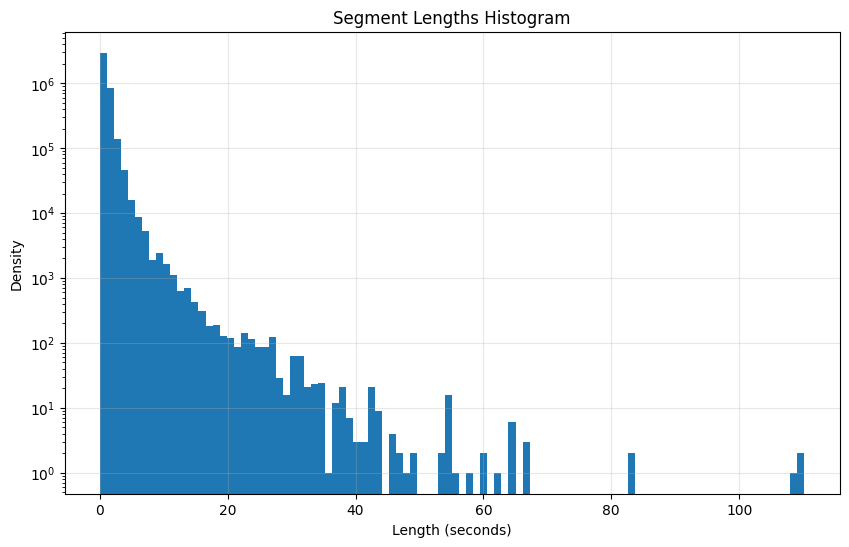

In [17]:
# Plot the distribution of segment lengths
plt.figure(figsize=(10, 6))
plt.hist(segment_lengths, bins=100)
plt.title('Segment Lengths Histogram')
plt.xlabel('Length (seconds)')
plt.ylabel('Density')
plt.yscale('log')
plt.grid(True, alpha=0.3)